**ALEXNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
data_path = '/content/drive/My Drive/Plant_Dataset'
os.listdir(data_path)

['Apple',
 'Potato',
 'Grape',
 'Strawberry',
 'Peach',
 'Tomato',
 'Corn',
 'Plant images.xlsx']

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class LimitedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None, limit_per_class=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.limit_per_class = limit_per_class
        self.samples = []
        self.classes = sorted([
            d for d in os.listdir(root_dir)
             if os.path.isdir(os.path.join(root_dir, d))
                   ])


        # Loop through each class folder
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            images = [
                os.path.join(class_path, f)
                for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            # Take only 500 images
            if len(images) > limit_per_class:
                images = random.sample(images, limit_per_class)

            for img_path in images:
                self.samples.append((img_path, label))

        print(f"Total images loaded: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ------------------------
# PATH TO YOUR DATASET
# ------------------------
data_dir = '/content/drive/My Drive/Plant_Dataset'

# image transforms
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset with limit=500
full_dataset = LimitedImageFolder(root_dir=data_dir, transform=data_transform, limit_per_class=1000)
classes = full_dataset.classes

# ------------------------
# SPLIT 70/30
# ------------------------
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len
train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)



Total images loaded: 7000


In [ ]:
# ------------------------
# 2. TRANSFER LEARNING - ALEXNET
# ------------------------

model = models.alexnet(pretrained=True)

# freeze all pretrained layers
for param in model.parameters():
    param.requires_grad = False

num_classes = len(classes)

# replace classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 203MB/s]


In [ ]:
# --- 3. Define loss, optimizer, learning rate ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)



In [ ]:
import torch
import numpy as np

num_epochs = 50                # maximum limit (it will stop earlier automatically)
patience = 5                  # stop after 5 epochs of no improvement
best_val_loss = np.inf
early_stop_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):

    # -----------------------------
    # Training
    # -----------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # -----------------------------
    # Validation
    # -----------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # -----------------------------
    # Early Stopping Logic
    # -----------------------------
    if epoch_val_loss < best_val_loss:
        print("✔ Validation loss improved — saving model")
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "alexnet_best.pth")
    else:
        early_stop_counter += 1
        print(f"❌ No improvement for {early_stop_counter} epochs")

        if early_stop_counter >= patience:
            print("\n⛔ Early stopping triggered!")
            break


Epoch 1/50 | Train Loss: 0.0674 | Train Acc: 0.9831 | Val Loss: 0.0541 | Val Acc: 0.9848
✔ Validation loss improved — saving model
Epoch 2/50 | Train Loss: 0.0760 | Train Acc: 0.9771 | Val Loss: 0.0554 | Val Acc: 0.9848
❌ No improvement for 1 epochs
Epoch 3/50 | Train Loss: 0.0682 | Train Acc: 0.9788 | Val Loss: 0.0523 | Val Acc: 0.9843
✔ Validation loss improved — saving model
Epoch 4/50 | Train Loss: 0.0742 | Train Acc: 0.9757 | Val Loss: 0.0529 | Val Acc: 0.9843
❌ No improvement for 1 epochs
Epoch 5/50 | Train Loss: 0.0695 | Train Acc: 0.9792 | Val Loss: 0.0588 | Val Acc: 0.9824
❌ No improvement for 2 epochs
Epoch 6/50 | Train Loss: 0.0710 | Train Acc: 0.9784 | Val Loss: 0.0561 | Val Acc: 0.9848
❌ No improvement for 3 epochs
Epoch 7/50 | Train Loss: 0.0729 | Train Acc: 0.9800 | Val Loss: 0.0552 | Val Acc: 0.9833
❌ No improvement for 4 epochs
Epoch 8/50 | Train Loss: 0.0761 | Train Acc: 0.9763 | Val Loss: 0.0536 | Val Acc: 0.9862
❌ No improvement for 5 epochs

⛔ Early stopping trigge

In [ ]:

import torch

# Path to save on Drive
save_path = "/content/drive/MyDrive/alexnet_finetuned1.pth"

torch.save(model.state_dict(), save_path)
print("Model saved to Google Drive!")




Model saved to Google Drive!


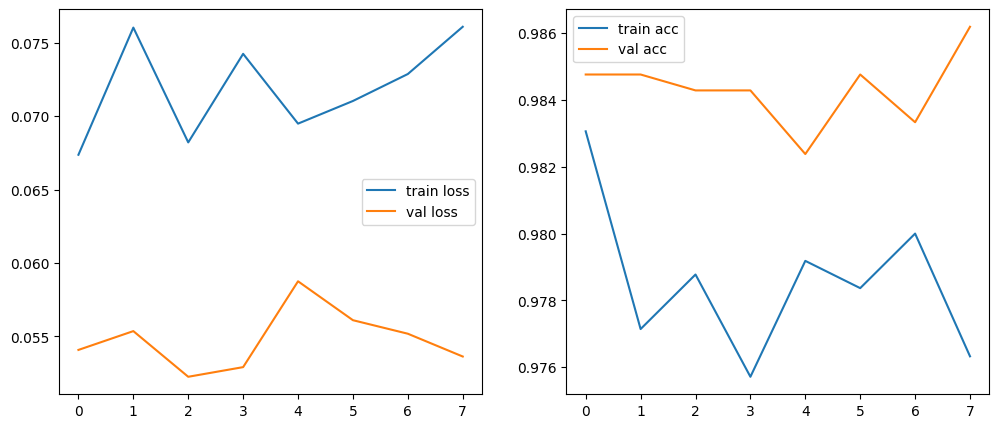

In [ ]:
# --- 6. Plot learning curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
plt.show()

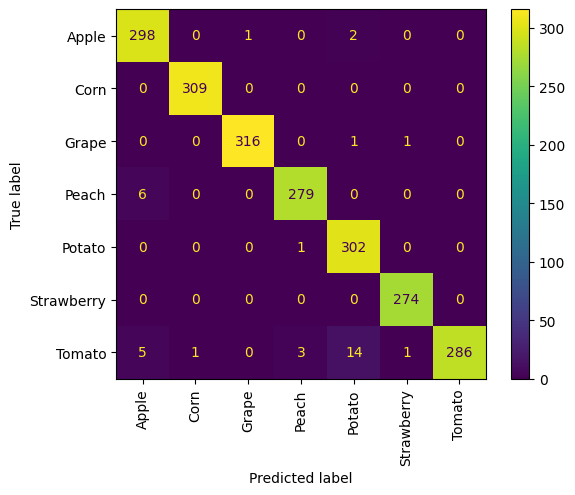

In [ ]:
# --- 7. Confusion matrix on test set ---
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()

In [ ]:
# --- 8. Load model and predict a sample image ---
from PIL import Image
def predict_image(img_path, model, transform, classes):
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return classes[pred.item()]

In [ ]:
model = models.alexnet(pretrained=False)

# Replace classifier same way as training
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(9216, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(classes))
)

model.load_state_dict(torch.load("/content/drive/My Drive/alexnet_finetuned1.pth", map_location=device))
model = model.to(device)
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=256, bias=True)
  

In [ ]:
img_path = "/content/drive/My Drive/Plant_Dataset/Strawberry/RS_L.Scorch_9999_resized.JPG"

prediction = predict_image(img_path, model, data_transform, classes)

print("Predicted class:", prediction)


Predicted class: Strawberry


Prediction: Strawberry


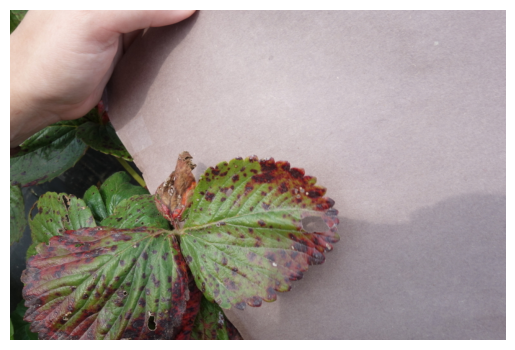

In [ ]:
import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
print("Prediction:", predict_image(img_path, model, data_transform, classes))


**VGGNET**

In [ ]:
import os, shutil
from glob import glob
import random

original_path = "/content/drive/My Drive/Plant_Dataset"
dataset_path = "/content/plant_half_dataset"

os.makedirs(dataset_path, exist_ok=True)

classes = os.listdir(original_path)

for cls in classes:
    src_folder = os.path.join(original_path, cls)
    if not os.path.isdir(src_folder):
        continue

    imgs = glob(src_folder + "/*")
    half_count = len(imgs) // 2     # use 50% images
    selected = random.sample(imgs, half_count)

    dest_folder = os.path.join(dataset_path, cls)
    os.makedirs(dest_folder, exist_ok=True)

    for img in selected:
        shutil.copy(img, dest_folder)

print("Half dataset created at:", dataset_path)


Half dataset created at: /content/plant_half_dataset


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

train_path = "/content/train"
test_path  = "/content/test"

shutil.rmtree(train_path, ignore_errors=True)
shutil.rmtree(test_path, ignore_errors=True)

os.makedirs(train_path)
os.makedirs(test_path)

classes = os.listdir(dataset_path)

for cls in classes:
    imgs = glob(os.path.join(dataset_path, cls, "*"))
    train_imgs, test_imgs = train_test_split(imgs, test_size=0.30, random_state=42)

    os.makedirs(os.path.join(train_path, cls))
    os.makedirs(os.path.join(test_path, cls))

    for i in train_imgs:
        shutil.copy(i, os.path.join(train_path, cls))

    for i in test_imgs:
        shutil.copy(i, os.path.join(test_path, cls))

print("Train/Test Split Completed!")


Train/Test Split Completed!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH = 32

train_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH,
    class_mode='categorical', shuffle=False
)

num_classes = len(train_data.class_indices)
print("Classes:", train_data.class_indices)


Found 11675 images belonging to 7 classes.
Found 5008 images belonging to 7 classes.
Classes: {'Apple': 0, 'Corn': 1, 'Grape': 2, 'Peach': 3, 'Potato': 4, 'Strawberry': 5, 'Tomato': 6}


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

base = VGG16(weights="imagenet", include_top=False,
             input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base.layers:
    layer.trainable = False  # freeze all convolution layers

x = Flatten()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(base.input, output)
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 327s 853ms/step - accuracy: 0.8017 - loss: 0.9127 - val_accuracy: 0.9804 - val_loss: 0.0636
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 280s 767ms/step - accuracy: 0.9536 - loss: 0.1417 - val_accuracy: 0.9768 - val_loss: 0.0630
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 282s 773ms/step - accuracy: 0.9561 - loss: 0.1194 - val_accuracy: 0.9806 - val_loss: 0.0539
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 281s 769ms/step - accuracy: 0.9621 - loss: 0.1026 - val_accuracy: 0.9816 - val_loss: 0.0537
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 286s 783ms/step - accuracy: 0.9635 - loss: 0.1026 - val_accuracy: 0.9754 - val_loss: 0.0778
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 276s 757ms/step - accuracy: 0.9671 - loss: 0.0930 - val_accuracy: 0.9878 - val_loss: 0.0330
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 282s 774ms/step - accuracy: 0.9718 - loss: 0.0811 - val_accuracy: 0.9872 - val_loss: 0.0357
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 281s 770ms/step - accuracy: 0.9749 -

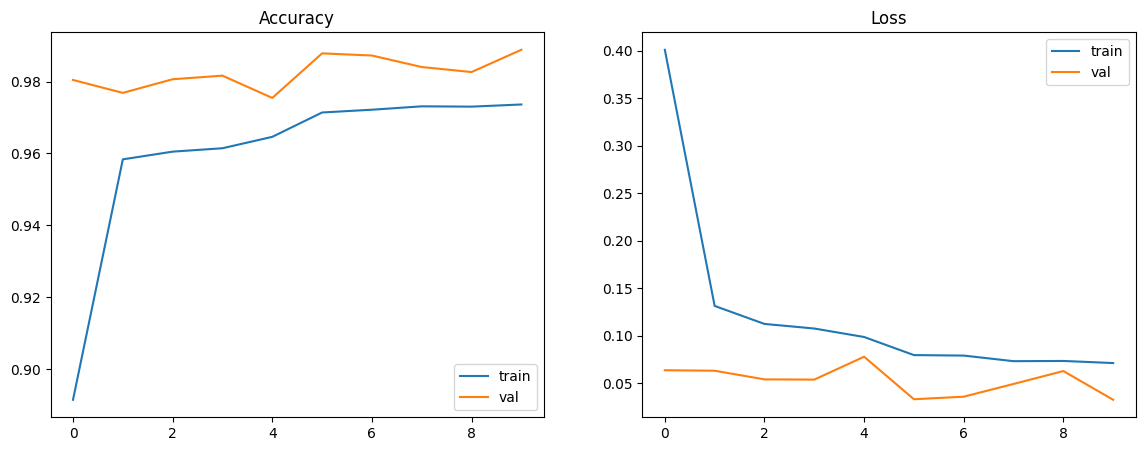

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['train','val'])

# loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['train','val'])

plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 426ms/step


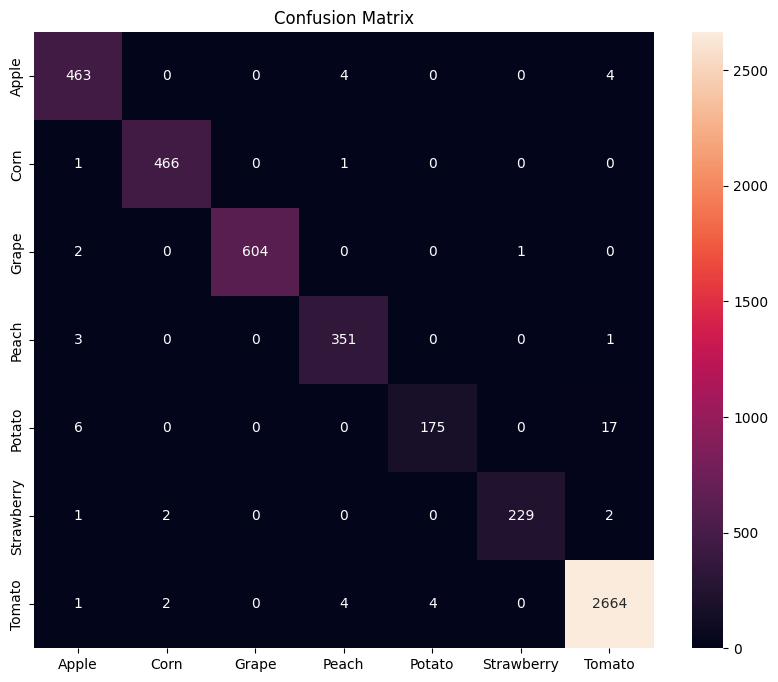

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Y_true = test_data.classes
Y_pred = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("/content/drive/My Drive/vgg_plant_model.keras")

print("Model saved!")



Model saved!


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("/content/drive/My Drive/vgg_plant_model.keras")

img_path = "/content/drive/MyDrive/leaf.jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_id = np.argmax(pred)

labels = list(train_data.class_indices.keys())
print("Predicted Class:", labels[class_id])


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Strawberry
